In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
dataset = pd.read_csv("keystrokes.csv")

subjects = ['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011', 's012', 's013',
 's015', 's016', 's017', 's018', 's019', 's020', 's021', 's022', 's024', 's025',
 's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034', 's035',
 's036', 's037', 's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046',
 's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054', 's055', 's056',
 's057']

In [3]:
for subject in subjects:
    dataset[subject] = [1 if x == subject else 0 for x in dataset['subject']]

In [4]:
TRAIN, TEST = 0.9, 0.1

x = dataset.drop(subjects + ['subject', 'sessionIndex', 'rep', 'H.period'], axis=1)

y = dataset[subjects]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=TRAIN, test_size=TEST)

x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(18360, 30) (2040, 30) (18360, 51) (2040, 51)


In [5]:
x_train = x_train.reshape(x_train.shape[0], 10, 3)
x_test = x_test.reshape(x_test.shape[0], 10, 3)

In [6]:
BATCH_SIZE = 50
EPOCHS = 20
VALIDATION_SPLIT = 0.1
NUMBER_OF_LAYERS = 3

model = Sequential()
if NUMBER_OF_LAYERS == 1:
    model.add(LSTM(256, input_shape=(10, 3), activation='tanh'))
    model.add(Dropout(0.5))
else:
    model.add(LSTM(256, input_shape=(10, 3), return_sequences='true', activation='tanh'))
    model.add(Dropout(0.5))
    for i in range(NUMBER_OF_LAYERS - 2):
        model.add(LSTM(256, return_sequences='true', activation='tanh'))
        model.add(Dropout(0.5))
    model.add(LSTM(256, activation='tanh'))
    model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, verbose=1)

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.0665 - loss: 3.5774 - val_accuracy: 0.2854 - val_loss: 2.4705
Epoch 2/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.2665 - loss: 2.5268 - val_accuracy: 0.3306 - val_loss: 2.2928
Epoch 3/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.3398 - loss: 2.2294 - val_accuracy: 0.4679 - val_loss: 1.8977
Epoch 4/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.4260 - loss: 1.9550 - val_accuracy: 0.4929 - val_loss: 1.7343
Epoch 5/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.4876 - loss: 1.7620 - val_accuracy: 0.5376 - val_loss: 1.5725
Epoch 6/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.5207 - loss: 1.6154 - val_accuracy: 0.6231 - val_loss: 1.3044
Epoch 7/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.5649 - loss: 1.4534 - val_accuracy: 0.6552 - val_loss: 1.1748
Epoch 8/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.6114 - loss: 1.3044 - 

In [7]:
score, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8821 - loss: 0.4142
Test score: 0.40692993998527527
Test accuracy: 0.8838235139846802


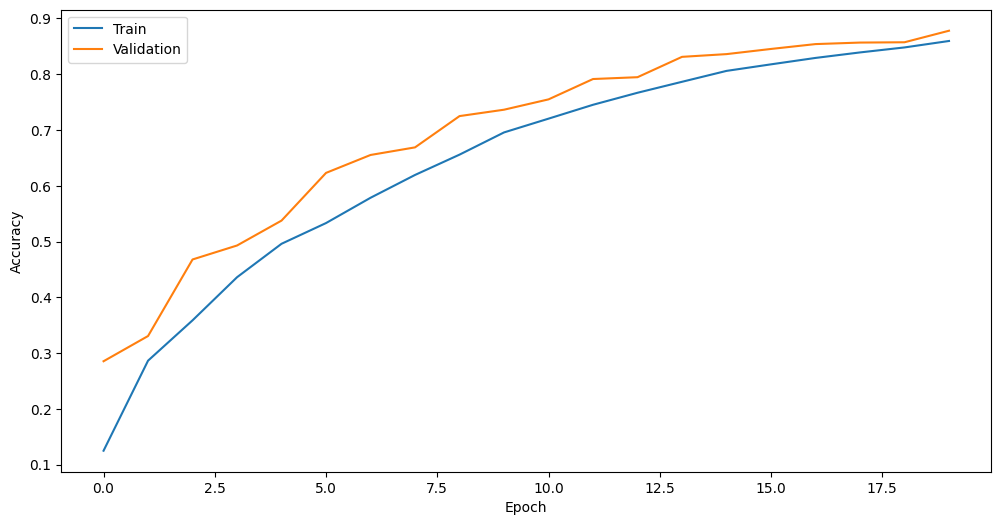

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
EER: 0.04190196078431373


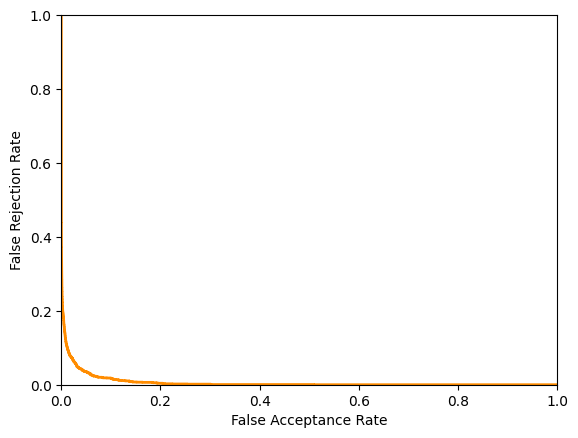

In [9]:
y_pred = model.predict(x_test)
y_pred = y_pred.ravel()
y_test = y_test.ravel()

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fnr = 1 - tpr
differences = np.absolute(fnr - fpr)
eer = fpr[np.argmin(differences)]

print('EER:', eer)

plt.figure()
plt.plot(fpr, fnr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Acceptance Rate')
plt.ylabel('False Rejection Rate')
# plt.title('ROC Curve for Fixed Text RNN')
plt.show()